In [1]:
import os
import copy
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# RDKit
import rdkit
from rdkit import Chem
from rdkit.Chem.rdmolfiles import MolFromXYZFile
from rdkit.Chem import rdDetermineBonds, rdFMCS
from rdkit.Chem.Draw import IPythonConsole
rdkit.__version__

'2023.09.2'

In [2]:
# Path to main folder where all the data is
folder_path = '../GNN_XAS_Node/raw_data/OPT_output'
# Create a list with the path of all the different molecule folders
subdirs = [os.path.join(folder_path, d) for d in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, d))]

print(len(subdirs))
print(subdirs)

92
['../GNN_XAS_Node/raw_data/OPT_output/cir_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_2_eKETO_0_iOH_1_iEPOXY_0_ieEPOXY_2_2', '../GNN_XAS_Node/raw_data/OPT_output/cir_R_eOH_0_eCOOH__0_eEPOXY_1_eCHO_2_eKETO_0_iOH_0_iEPOXY_0_ieEPOXY_2_2', '../GNN_XAS_Node/raw_data/OPT_output/cir_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_1_iOH_0_iEPOXY_2_ieEPOXY_1_0', '../GNN_XAS_Node/raw_data/OPT_output/cir_R_eOH_0_eCOOH__2_eEPOXY_0_eCHO_0_eKETO_1_iOH_0_iEPOXY_1_ieEPOXY_1_2', '../GNN_XAS_Node/raw_data/OPT_output/cir_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_1_iOH_0_iEPOXY_0_ieEPOXY_2_1', '../GNN_XAS_Node/raw_data/OPT_output/cir_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_0_iEPOXY_3_ieEPOXY_0_2', '../GNN_XAS_Node/raw_data/OPT_output/cir_R_eOH_0_eCOOH__0_eEPOXY_1_eCHO_0_eKETO_0_iOH_3_iEPOXY_1_ieEPOXY_0_0', '../GNN_XAS_Node/raw_data/OPT_output/cir_R_eOH_1_eCOOH__1_eEPOXY_1_eCHO_0_eKETO_1_iOH_0_iEPOXY_1_ieEPOXY_0_2', '../GNN_XAS_Node/raw_data/OPT_output/cir_R_eOH_2_eCOOH__1_eEPOXY_1_eCHO_0_eKETO_1_iOH_0_iEPOXY_0_ieEPOXY_0_0

In [3]:
foldername = []
# Split up the into the directory path and list of all the folder/molecule names
for subdir in subdirs:
    dirpath, temp = os.path.split(subdir)
    foldername.append(temp)

print(len(foldername))
print(foldername)
print(dirpath)

92
['cir_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_2_eKETO_0_iOH_1_iEPOXY_0_ieEPOXY_2_2', 'cir_R_eOH_0_eCOOH__0_eEPOXY_1_eCHO_2_eKETO_0_iOH_0_iEPOXY_0_ieEPOXY_2_2', 'cir_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_1_iOH_0_iEPOXY_2_ieEPOXY_1_0', 'cir_R_eOH_0_eCOOH__2_eEPOXY_0_eCHO_0_eKETO_1_iOH_0_iEPOXY_1_ieEPOXY_1_2', 'cir_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_1_iOH_0_iEPOXY_0_ieEPOXY_2_1', 'cir_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_0_iEPOXY_3_ieEPOXY_0_2', 'cir_R_eOH_0_eCOOH__0_eEPOXY_1_eCHO_0_eKETO_0_iOH_3_iEPOXY_1_ieEPOXY_0_0', 'cir_R_eOH_1_eCOOH__1_eEPOXY_1_eCHO_0_eKETO_1_iOH_0_iEPOXY_1_ieEPOXY_0_2', 'cir_R_eOH_2_eCOOH__1_eEPOXY_1_eCHO_0_eKETO_1_iOH_0_iEPOXY_0_ieEPOXY_0_0', 'cir_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_1_eKETO_0_iOH_3_iEPOXY_1_ieEPOXY_0_2', 'cir_R_eOH_0_eCOOH__0_eEPOXY_1_eCHO_1_eKETO_0_iOH_0_iEPOXY_1_ieEPOXY_2_2', 'cir_R_eOH_0_eCOOH__0_eEPOXY_1_eCHO_2_eKETO_0_iOH_0_iEPOXY_0_ieEPOXY_0_1', 'cir_R_eOH_0_eCOOH__1_eEPOXY_0_eCHO_0_eKETO_1_iOH_1_iEPOXY_2_ieEPOXY_0_0', 'cir_R_eOH_0_eCOOH__1

In [4]:
pattern = r'OPT_[\w]+\.xyz'
xyz_files = []
# Loop through all the molecule folders and get the OPT.xyz files
for subdir in subdirs:
    files = [f for f in os.listdir(subdir) if os.path.isfile(os.path.join(subdir, f))]

    for filename in files:
        if re.match(pattern, filename):
            xyz_file = filename
            xyz_files.append(xyz_file)

print(xyz_files)

['OPT_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_2_eKETO_0_iOH_1_iEPOXY_0_ieEPOXY_2_2.xyz', 'OPT_R_eOH_0_eCOOH__0_eEPOXY_1_eCHO_2_eKETO_0_iOH_0_iEPOXY_0_ieEPOXY_2_2.xyz', 'OPT_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_1_iOH_0_iEPOXY_2_ieEPOXY_1_0.xyz', 'OPT_R_eOH_0_eCOOH__2_eEPOXY_0_eCHO_0_eKETO_1_iOH_0_iEPOXY_1_ieEPOXY_1_2.xyz', 'OPT_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_1_iOH_0_iEPOXY_0_ieEPOXY_2_1.xyz', 'OPT_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_0_iEPOXY_3_ieEPOXY_0_2.xyz', 'OPT_R_eOH_0_eCOOH__0_eEPOXY_1_eCHO_0_eKETO_0_iOH_3_iEPOXY_1_ieEPOXY_0_0.xyz', 'OPT_R_eOH_1_eCOOH__1_eEPOXY_1_eCHO_0_eKETO_1_iOH_0_iEPOXY_1_ieEPOXY_0_2.xyz', 'OPT_R_eOH_2_eCOOH__1_eEPOXY_1_eCHO_0_eKETO_1_iOH_0_iEPOXY_0_ieEPOXY_0_0.xyz', 'OPT_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_1_eKETO_0_iOH_3_iEPOXY_1_ieEPOXY_0_2.xyz', 'OPT_R_eOH_0_eCOOH__0_eEPOXY_1_eCHO_1_eKETO_0_iOH_0_iEPOXY_1_ieEPOXY_2_2.xyz', 'OPT_R_eOH_0_eCOOH__0_eEPOXY_1_eCHO_2_eKETO_0_iOH_0_iEPOXY_0_ieEPOXY_0_1.xyz', 'OPT_R_eOH_0_eCOOH__1_eEPOXY_0_eCHO_0_eKETO_1_iOH_1

In [5]:
def rearrange_xyz(path, filename):

    '''
    Function that rearranges the given .xyz file to move all the
    oxygen and hydrogen atoms to the bottom of the file
    '''

    with open(os.path.join(path, filename), 'r') as fr:
        lines = fr.readlines()
        o_lines = []
        h_lines = []

        for line in lines:
            if line.startswith('  O'):
                o_lines.append(line)
            elif line.startswith('  H'):
                h_lines.append(line)

        with open(os.path.join(path, filename), 'w') as fw:

            for line in lines:
                if line.startswith('  H'):
                    pass
                elif line.startswith('  O'):
                    pass
                else:
                    fw.write(line)
        
            for x in o_lines:
                fw.write(x)

            for y in h_lines:
                fw.write(y)

In [6]:
# Run the rearrange_xyz function on all the molecules
for subdir, f in zip(subdirs, xyz_files):
    rearrange_xyz(subdir, f)

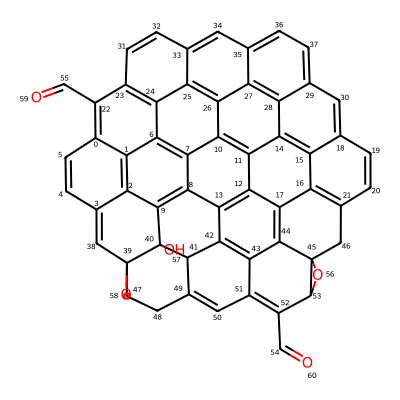

In [7]:
IPythonConsole.drawOptions.addAtomIndices=True
IPythonConsole.molSize = 400,400

raw_mol = MolFromXYZFile(os.path.join(subdirs[0], xyz_files[0]))
conn_mol = Chem.Mol(raw_mol)
rdDetermineBonds.DetermineBonds(conn_mol)
mol = copy.deepcopy(conn_mol)
mol = Chem.RemoveAllHs(mol)
Chem.RemoveStereochemistry(mol)
mol

In [8]:
smi = Chem.MolToSmiles(mol)
print(smi)

O=CC1=C2C=C3CC4OC45C=c4ccc6c(C=O)c7ccc8cc9ccc%10cc%11ccc%12c%13c%14c(c2c2c%15c%16c(c4c6c4c7c8c6c9c%10c(c%11%13)c(c%14%15)c6c%164)C5(O)C32)C2(C%12)OC12


In [9]:
Chem.AssignStereochemistry(mol, cleanIt=True, force=True, flagPossibleStereoCenters=True)

t = [[atom.GetIdx(), atom.GetProp('_CIPRank')] for atom in mol.GetAtoms()]

symm_dict = {}

for atom in mol.GetAtoms():
    symm_dict[atom.GetIdx()] = atom.GetProp('_CIPRank')

print(symm_dict)

{0: '29', 1: '46', 2: '47', 3: '48', 4: '12', 5: '9', 6: '45', 7: '40', 8: '33', 9: '21', 10: '44', 11: '43', 12: '35', 13: '31', 14: '41', 15: '34', 16: '30', 17: '32', 18: '24', 19: '4', 20: '2', 21: '18', 22: '22', 23: '28', 24: '39', 25: '38', 26: '42', 27: '37', 28: '36', 29: '25', 30: '10', 31: '8', 32: '7', 33: '27', 34: '11', 35: '26', 36: '6', 37: '5', 38: '14', 39: '53', 40: '51', 41: '13', 42: '19', 43: '17', 44: '20', 45: '52', 46: '1', 47: '49', 48: '0', 49: '15', 50: '3', 51: '16', 52: '23', 53: '50', 54: '55', 55: '54', 56: '57', 57: '56', 58: '58', 59: '59', 60: '60'}


In [10]:
for i, atom in enumerate(mol.GetAtoms()):
    atom.SetProp("molAtomMapNumber", str(atom.GetIdx()))


In [11]:
loc_dircs = [os.path.join(subdirs[0], d) for d in os.listdir(subdirs[0]) if os.path.isdir(os.path.join(subdirs[0], d))]
print(loc_dircs)

['../GNN_XAS_Node/raw_data/OPT_output/cir_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_2_eKETO_0_iOH_1_iEPOXY_0_ieEPOXY_2_2/53', '../GNN_XAS_Node/raw_data/OPT_output/cir_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_2_eKETO_0_iOH_1_iEPOXY_0_ieEPOXY_2_2/9', '../GNN_XAS_Node/raw_data/OPT_output/cir_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_2_eKETO_0_iOH_1_iEPOXY_0_ieEPOXY_2_2/20', '../GNN_XAS_Node/raw_data/OPT_output/cir_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_2_eKETO_0_iOH_1_iEPOXY_0_ieEPOXY_2_2/51', '../GNN_XAS_Node/raw_data/OPT_output/cir_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_2_eKETO_0_iOH_1_iEPOXY_0_ieEPOXY_2_2/10', '../GNN_XAS_Node/raw_data/OPT_output/cir_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_2_eKETO_0_iOH_1_iEPOXY_0_ieEPOXY_2_2/55', '../GNN_XAS_Node/raw_data/OPT_output/cir_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_2_eKETO_0_iOH_1_iEPOXY_0_ieEPOXY_2_2/36', '../GNN_XAS_Node/raw_data/OPT_output/cir_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_2_eKETO_0_iOH_1_iEPOXY_0_ieEPOXY_2_2/58', '../GNN_XAS_Node/raw_data/OPT_output/cir_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_2_eKETO_0_iOH_1_

In [12]:
loc_names = [f for f in os.listdir(subdirs[0]) if os.path.isdir(os.path.join(subdirs[0], f))]
print(loc_names)

['53', '9', '20', '51', '10', '55', '36', '58', '26', '43', '23', '39', '8', '30', '49', '14', '12', '46', '19', '15', '45', '40', '59', '34', '41', '60', '47', '18', '29', '11', '57', '7', '25', '35', '33', '44', '42', '31', '48', '37', '38', '24', '50', '28', '6', '13', '54', '16', '52', '17', '5', '21', '56', '27', '22', '32']


In [13]:
name_dirs = [x[1] for x in os.walk(subdirs[0])][0]
print(name_dirs)

['53', '9', '20', '51', '10', '55', '36', '58', '26', '43', '23', '39', '8', '30', '49', '14', '12', '46', '19', '15', '45', '40', '59', '34', '41', '60', '47', '18', '29', '11', '57', '7', '25', '35', '33', '44', '42', '31', '48', '37', '38', '24', '50', '28', '6', '13', '54', '16', '52', '17', '5', '21', '56', '27', '22', '32']


In [14]:
spec_dict = {}

for i in range(len(loc_dircs)):
    loc_dir = loc_dircs[i]

    loc_files = [f for f in os.listdir(loc_dir) if os.path.isfile(os.path.join(loc_dir, f))]

print(loc_files)

['OPT_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_2_eKETO_0_iOH_1_iEPOXY_0_ieEPOXY_2_2.xyz', 'slurm-7205457.out', 'R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_2_eKETO_0_iOH_1_iEPOXY_0_ieEPOXY_2_2.out.abs.dat', 'R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_2_eKETO_0_iOH_1_iEPOXY_0_ieEPOXY_2_2.xyz', 'R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_2_eKETO_0_iOH_1_iEPOXY_0_ieEPOXY_2_2_32.inp', 'R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_2_eKETO_0_iOH_1_iEPOXY_0_ieEPOXY_2_2.out.abs.stk', 'R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_2_eKETO_0_iOH_1_iEPOXY_0_ieEPOXY_2_2_32.sh']


In [17]:
x = np.linspace(280, 300, num=200, endpoint=True)
sigma = 0.6

for l_file in loc_files:
    if l_file.endswith('abs.stk'):
        spec_df = pd.read_csv('../GNN_XAS_Node/raw_data/OPT_output/cir_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_2_eKETO_0_iOH_1_iEPOXY_0_ieEPOXY_2_2/53/' + l_file,
                              sep='\s+', header=None, names=['Peak', 'Strength'])
        
        energies = spec_df['Peak']
        osc = spec_df['Strength']

        gE = []

        for Ei in x:
            tot = 0
            for Ej, os in zip(energies, osc):
                tot += os * np.exp(-((((Ej - Ei) / sigma) ** 2)))
                gE.append(tot)

In [16]:
test = '../GNN_XAS_Node/raw_data/OPT_output/cir_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_2_eKETO_0_iOH_1_iEPOXY_0_ieEPOXY_2_2/53/R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_2_eKETO_0_iOH_1_iEPOXY_0_ieEPOXY_2_2.out.abs.stk'

spec_df = pd.read_csv(test, sep='\s+', header=None, names=['Peaks', 'Strength'])

energies = spec_df['Peaks']
osc = spec_df['Strength']

print(energies)
print(osc)

0      287.08
1      287.66
2      288.30
3      288.51
4      288.77
        ...  
145    300.29
146    300.40
147    300.49
148    300.54
149    300.54
Name: Peaks, Length: 150, dtype: float64
0       183.985403
1        39.487893
2      1621.493381
3      1538.543553
4       125.149795
          ...     
145      66.773686
146       5.080747
147      71.000048
148      19.966299
149      16.798492
Name: Strength, Length: 150, dtype: float64


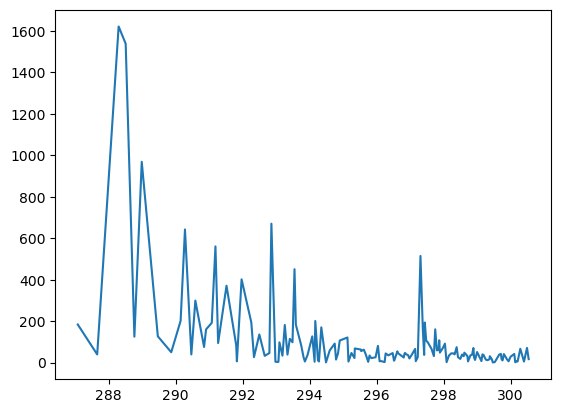

In [17]:
plt.plot(energies, osc)
plt.show()

In [23]:
x = np.linspace(280, 300, num=200, endpoint=True)
sigma = 0.4

gE = []

for Ei in x:
    tot = 0
    for Ej, os in zip(energies, osc):
        tot += os * np.exp(-((((Ej - Ei) / sigma) ** 2)))
    gE.append(tot)

print(gE)
print(len(gE))

[1.6020096658248326e-134, 1.0966511785552178e-130, 6.616649202906433e-127, 3.5186326913891934e-123, 1.649210075911934e-119, 6.813091921091976e-116, 2.480725667254168e-112, 7.961216872966636e-109, 2.2518859548909533e-105, 5.614092351591997e-102, 1.2336129948797433e-98, 2.3891561847581412e-95, 4.0782737153140835e-92, 6.135845589448897e-89, 8.136520001234606e-86, 9.509752050398935e-83, 9.796386558792749e-80, 8.894649861144061e-77, 7.118000636312143e-74, 5.020574444280568e-71, 3.1211527420948596e-68, 1.710184070390331e-65, 8.259179672508505e-63, 3.5155816903488763e-60, 1.3189359221468426e-57, 4.361304628690261e-55, 1.271087274575485e-52, 3.2651304878462054e-50, 7.392510265217872e-48, 1.47519541272278e-45, 2.5946177991232193e-43, 4.0221980921276175e-41, 5.495658541675693e-39, 6.618235997274968e-37, 7.02475174060819e-35, 6.571824158749484e-33, 5.418849775090684e-31, 3.9381704671939867e-29, 2.5225985020916065e-27, 1.4241901534732989e-25, 7.086863158678293e-24, 3.108181262353041e-22, 1.2015029

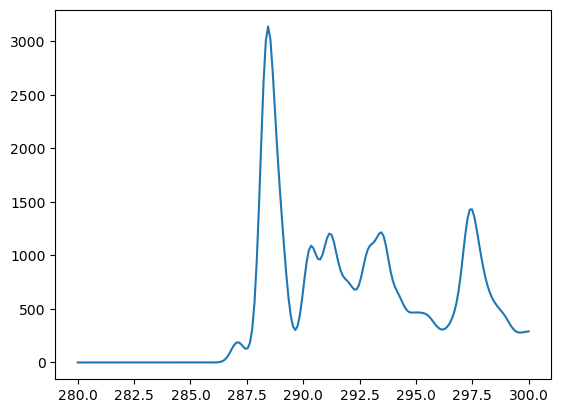

In [24]:
plt.plot(x, gE)
plt.show()